In [55]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import torch
from scipy.stats import zscore
import seaborn as sns

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from sklearn import preprocessing

from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer import Predictive
from sklearn.metrics import r2_score

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

We choose the dataset from [Kaggle](https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities), it provides a comprehensive overview of Airnb prices of some popular European cities. In this project, we select the file containing the information of Amsterdan during weekdays, each listing is evaluated for various attributes such as room types, cleanliness and satisfaction ratings, bedrooms, distance from the city centre, and more to capture an in-depth understanding of Airbnb prices. The objective is to predict the realSum(the total price of the Airnb listing) using given the other selected variables. The target variable is realSum.

In [56]:
df = pd.read_csv('amsterdam_weekdays.csv')
df.head()

,Unnamed: 0,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772
1,1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432
2,2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103
3,3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663
4,4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508


# Data Processing
For the dataset we choose, we think there are some features that are irrelated to our goal, so we only kept 14 of those variables. For boolean values in columns "room_shared" and "room_private", we replace 'False' with 0 and 'True' with 1. The dataset also contains one categorical features "room_type", and boolean value features "room_shared", "room_private", "multi", and "biz". Hence, we use the one-hot encoding method to transform the data.

In [57]:
#delete the first column-sequence number
df = df.drop(df.columns[0], axis=1)

# delete irrelevant variable columns
df = df.drop(['host_is_superhost','attr_index','attr_index_norm','rest_index','rest_index_norm'], axis=1)

# replace all False with 0, all True with 0
df = df.replace({False:0,True:1})

person_capacity = df.loc[:,'person_capacity']
df = df.drop('person_capacity', axis=1)
df.insert(13,'person_capacity',person_capacity)

# Feature columns holding categorical data
columns_cat = df.columns[1:6]

# Use one-hot encoding to transform categorical data
one_hot_encodings = {}
for i in range(len(columns_cat)):
    df_dummies = pd.get_dummies(df[columns_cat[i]], prefix = columns_cat[i])
    one_hot_encodings[columns_cat[i]] = df_dummies

# Drop original categorical columns
df = df.drop(columns=list(columns_cat))

# Append the one-hot encodings of the categorical columns
for _, value in one_hot_encodings.items():
    df = pd.concat([df, value], axis=1)
    
df.head()

,realSum,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,lng,lat,person_capacity,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,room_shared_0,room_shared_1,room_private_0,room_private_1,multi_0,multi_1,biz_0,biz_1
0,194.033698,10.0,93.0,1,5.022964,2.539380,4.90569,52.41772,2.0,0,1,0,1,0,0,1,0,1,1,0
1,344.245776,8.0,85.0,1,0.488389,0.239404,4.90005,52.37432,4.0,0,1,0,1,0,0,1,1,0,1,0
2,264.101422,9.0,87.0,1,5.748312,3.651621,4.97512,52.36103,2.0,0,1,0,1,0,0,1,1,0,0,1
3,433.529398,9.0,90.0,2,0.384862,0.439876,4.89417,52.37663,4.0,0,1,0,1,0,0,1,1,0,0,1
4,485.552926,10.0,98.0,1,0.544738,0.318693,4.90051,52.37508,2.0,0,1,0,1,0,0,1,1,0,1,0


We judge if there are some missing values in every column. If they exist, we replace them with the mean value.     
After checking, no missing value in out dataset.

In [58]:
# Determine whether a column has a missing value
print(df.isnull().any())

realSum                       False
cleanliness_rating            False
guest_satisfaction_overall    False
bedrooms                      False
dist                          False
metro_dist                    False
lng                           False
lat                           False
person_capacity               False
room_type_Entire home/apt     False
room_type_Private room        False
room_type_Shared room         False
room_shared_0                 False
room_shared_1                 False
room_private_0                False
room_private_1                False
multi_0                       False
multi_1                       False
biz_0                         False
biz_1                         False
dtype: bool


And then we check outliers. According to the boxplot of all variables, we cannot find the outliers. Therefore, we didn't remove any observations in our dataset.

In [59]:
# check if it exists outliers
X = np.array(df.iloc[:,:])

# standardize data set because of different scales
Y = zscore(X, ddof=1)

featureNames = df.columns.values.tolist()
M = len(featureNames)

Text(0.5, 1.0, 'boxplot(standarized)')

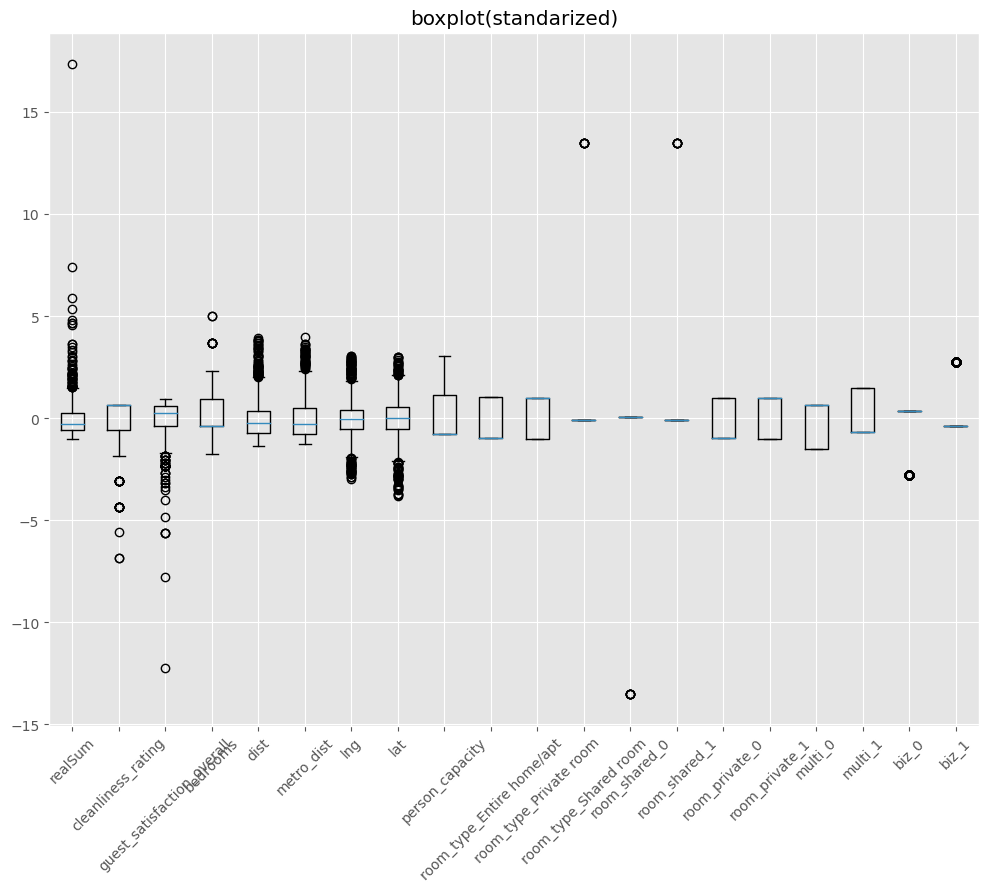

In [60]:
# a boxplot of each feature
plt.figure(figsize=(12,9))
plt.boxplot(Y)
plt.xticks(range(1,21), featureNames, rotation=45)
plt.title('boxplot(standarized)')

In order to use dataset easily, we output the dataset that we processed into a new file called ***_final_data.csv_***.

In [ ]:
# outputpath='final_data.csv'
# df.to_csv(outputpath,sep=',',index=False)

# Data visualization
We make a heatmap of correlation table among most of the attribute and visualize the data through lineplots. 
* The correlation matrix shows the correlation between variables.There are some strong correlation between the number of bedrooms, the maximum number of people that can stay in the room and the type of room ('bedrooms', 'room_type' and 'person_capacity'), guest satisfaction rating and cleanliness rating ('cleanliness_rating' and 'guest_satisfaction_overall'), which is to be expected. It also shows in our PGM figure distinctly.

<AxesSubplot:>

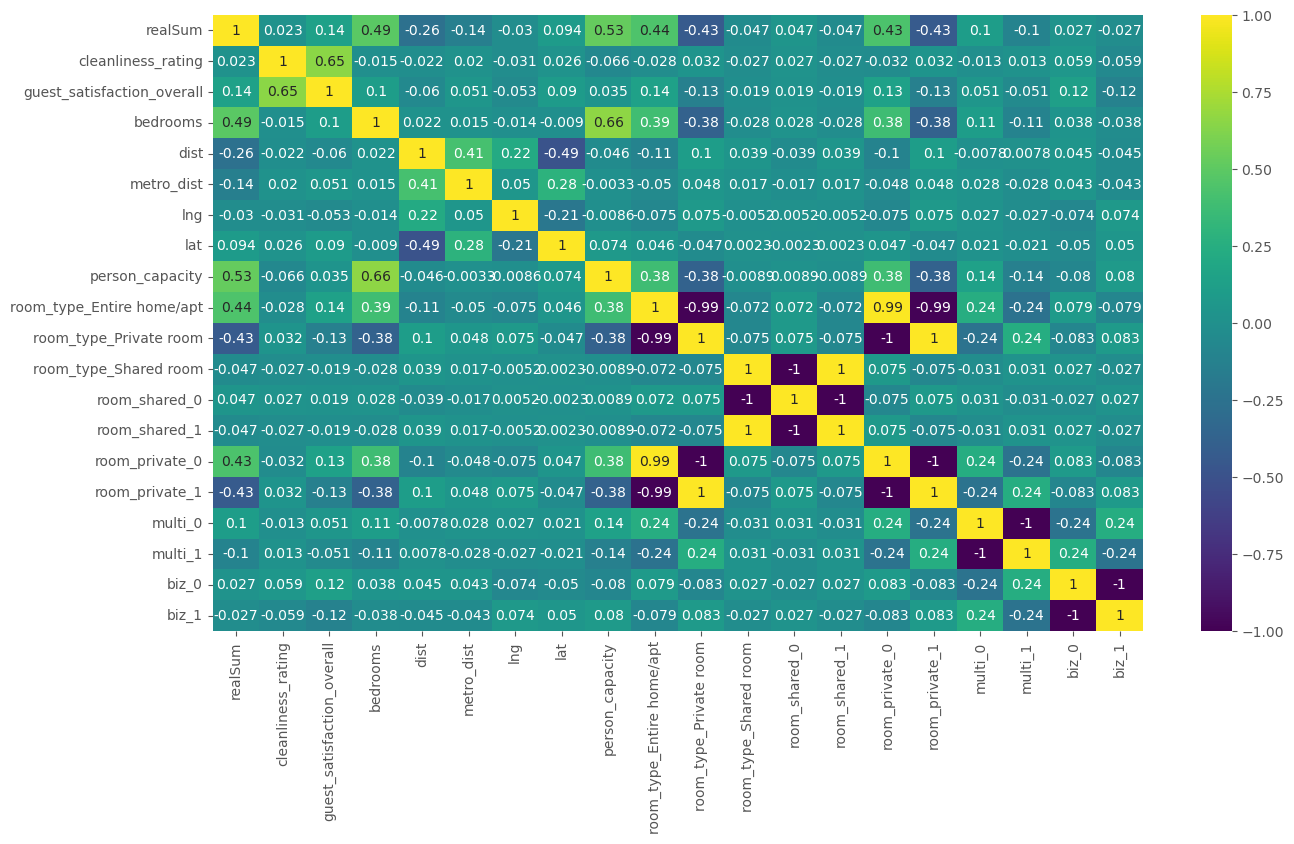

In [61]:
# draw the correlation figure between different features
col = df.columns[:]
corr = df[col].corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True, cmap = 'viridis')

<Figure size 800x500 with 0 Axes>

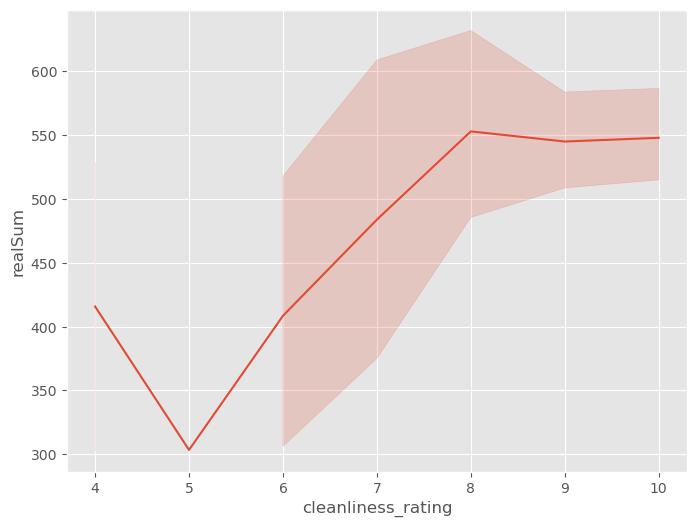

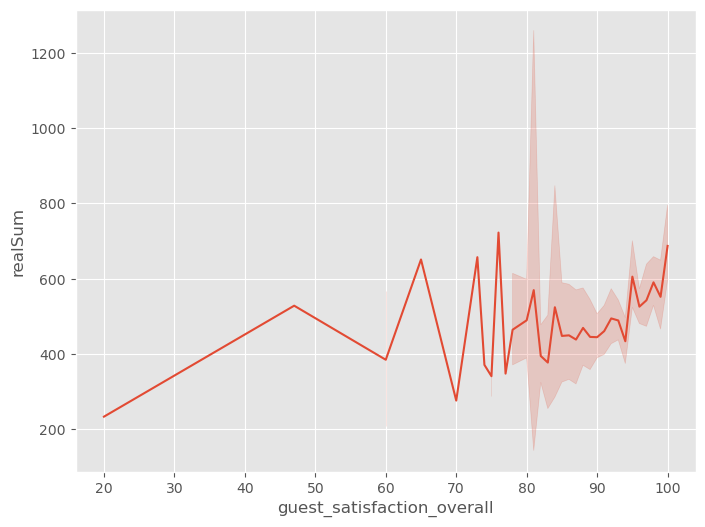

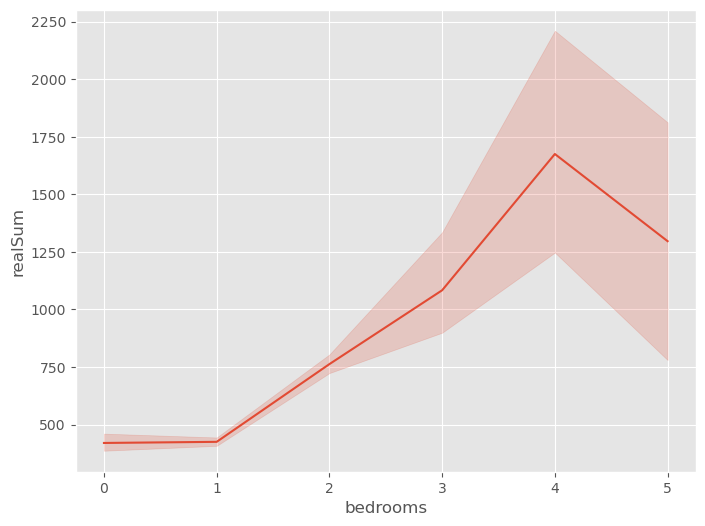

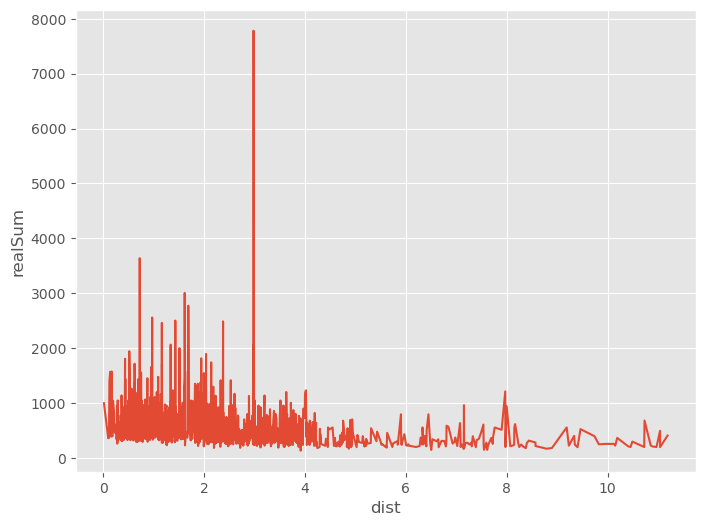

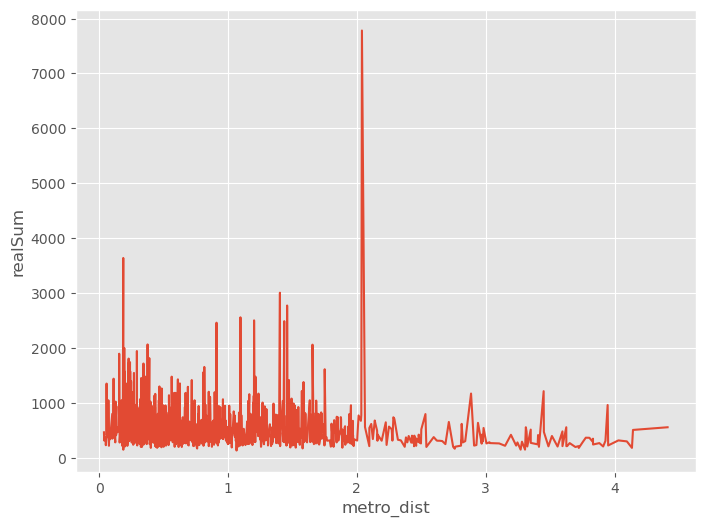

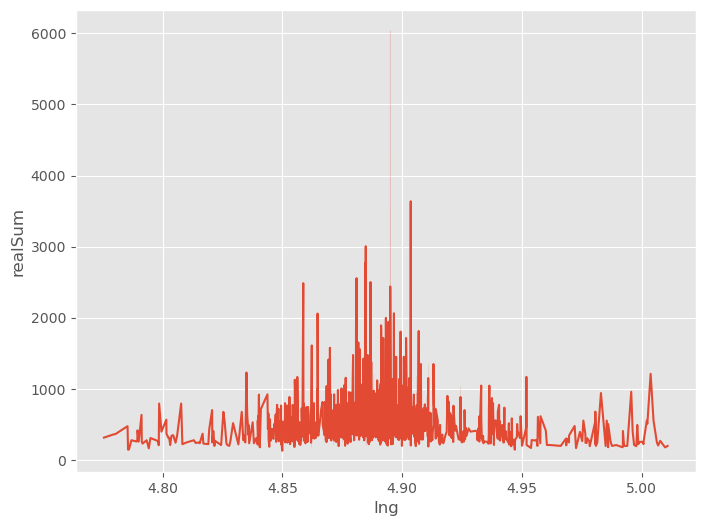

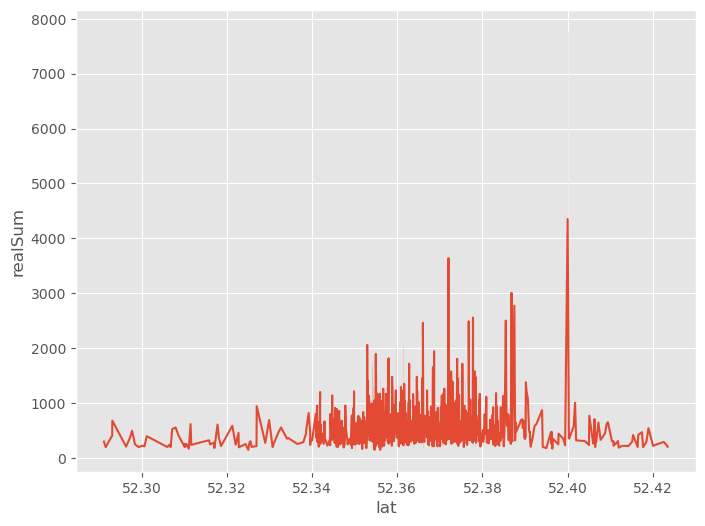

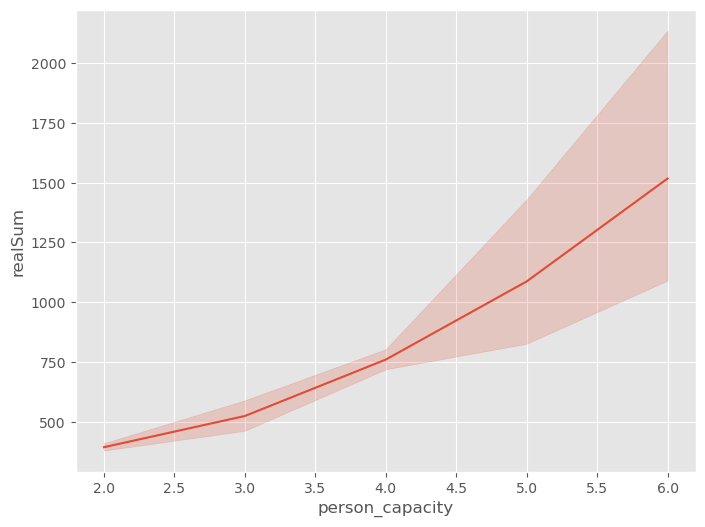

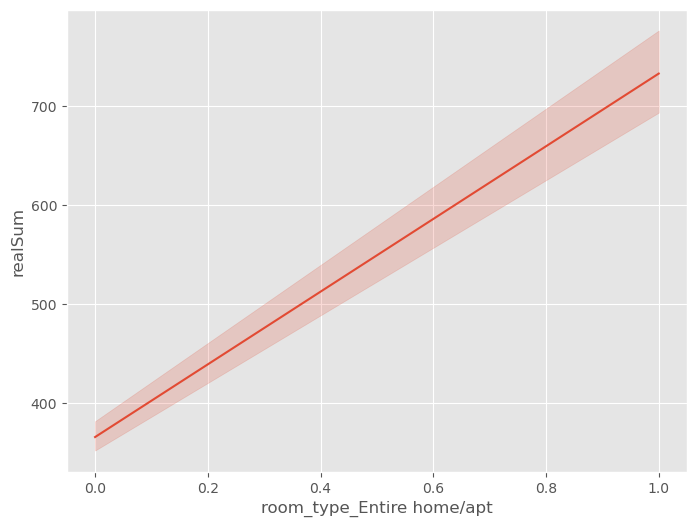

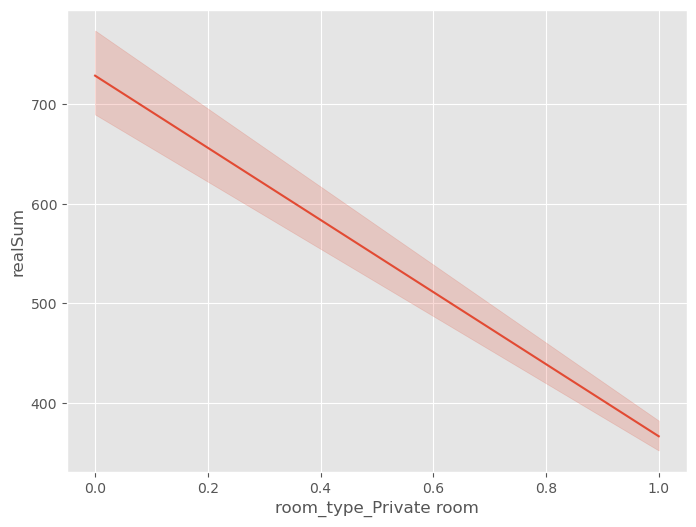

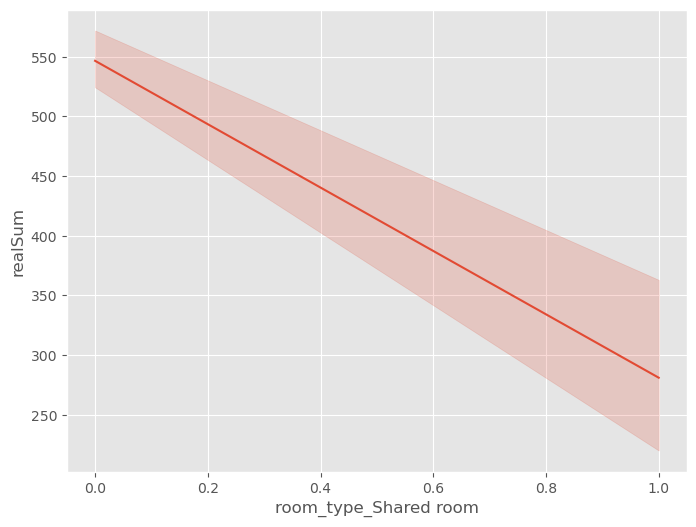

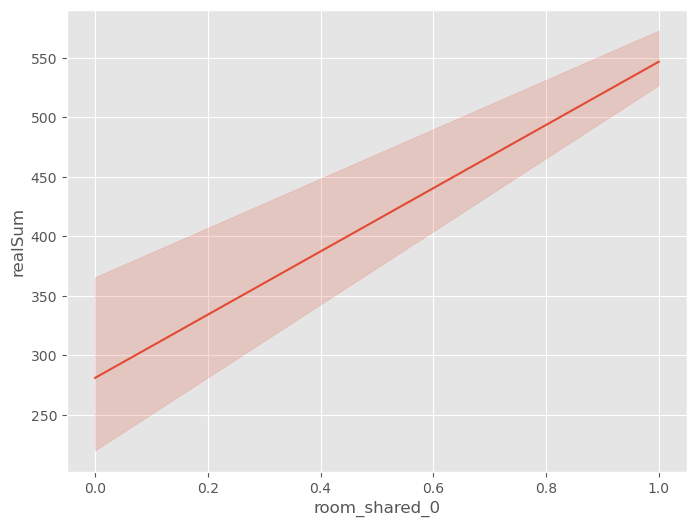

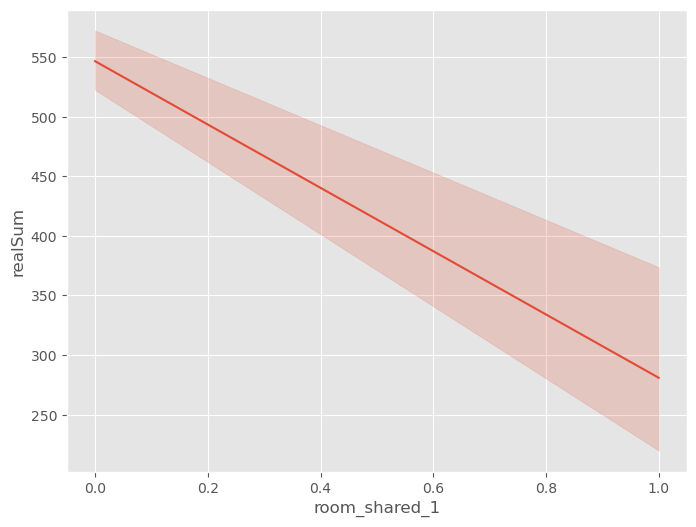

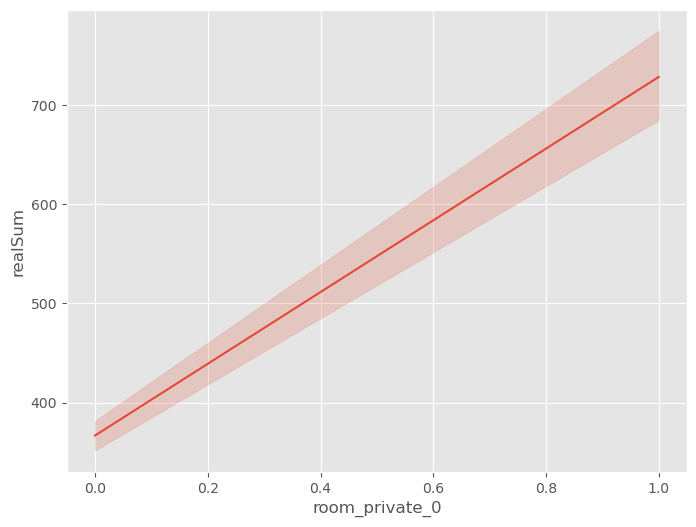

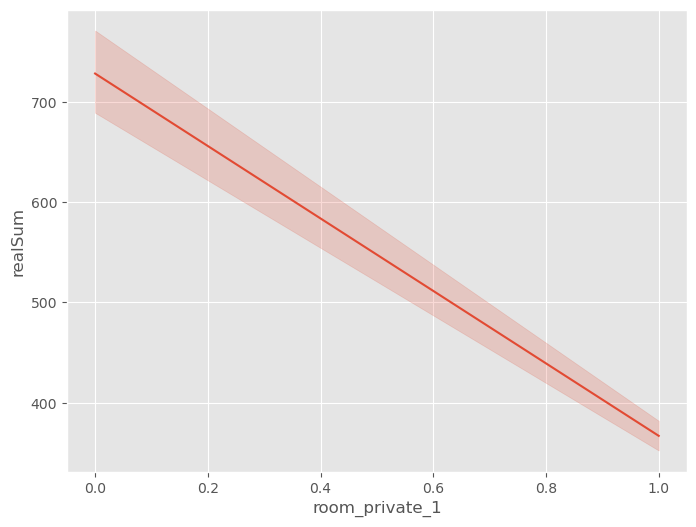

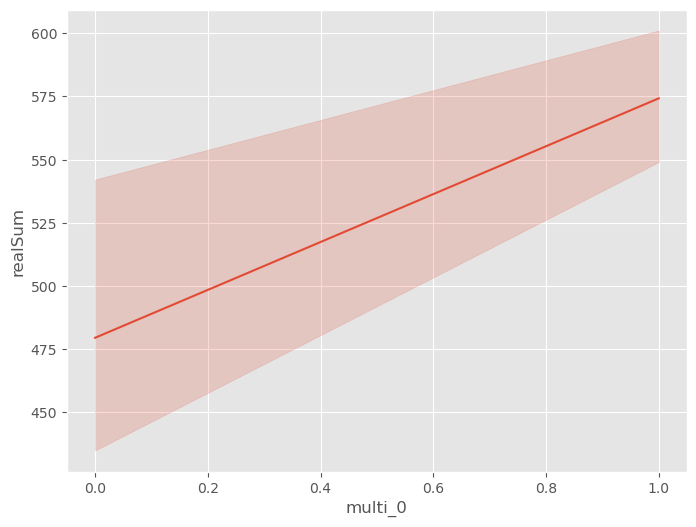

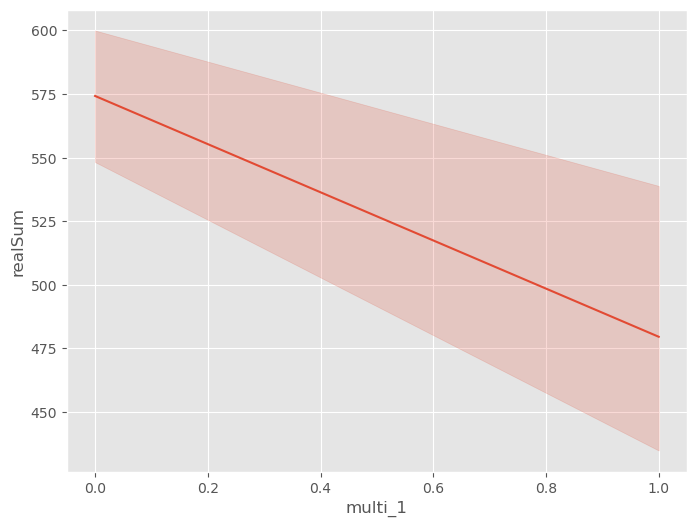

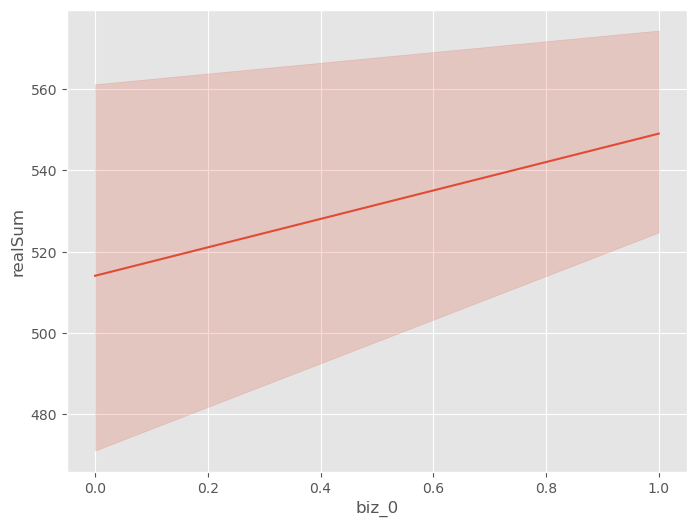

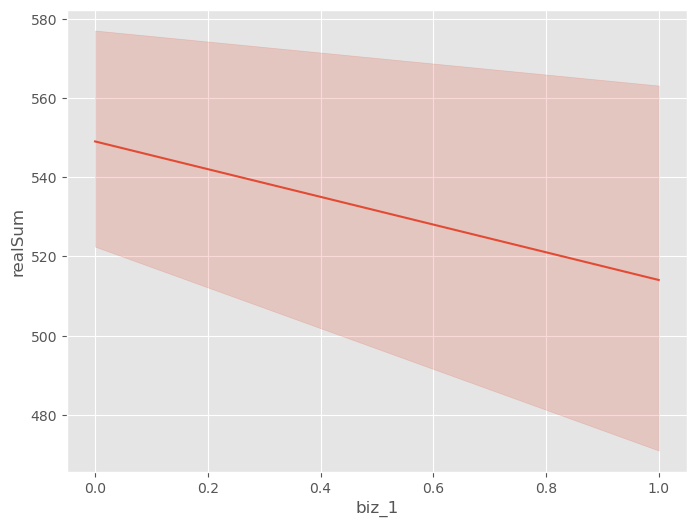

In [62]:
# draw the lineplot to show relationship between every variables and price
price = df["realSum"]
plt.figure(figsize=(8,5))
for col in df.columns[1:]:
    plt.figure()
    sns.lineplot(x=df[col],y=price)

In [63]:
df = pd.read_csv('final_data.csv')

In [64]:
# X: all input variables
X = np.array(df.iloc[:,1:])

N, D = X.shape
print("Vector of", N, "x", D)

Vector of 1103 x 19


In [65]:
# y: house price
y = np.array(df.iloc[:,0])
print(y.shape)

(1103,)


### Dividing the trainging set and testing set
We called the function ***_permutation_*** which can create a randomly ordered array of indexes to break up the data set. And the percentage of training data size is set to 0.66 of total observations, so the number of training data is 727 and that of testing data is 376.

In [66]:
# divide train set and test set
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 727
num test: 376


### Standardization
For our data set, all input variables have different scale, so we standardize the dataset, which ensures that they are in the same scale, avoiding certain features having a large range of values that can have an unwanted effect on the model.

In [67]:
''' Standardize '''
X_standardizer = preprocessing.StandardScaler()

X_train = X_standardizer.fit_transform(X_train)
X_test = X_standardizer.transform(X_test)

# Linear regression
First, we try to use linear regression for this dataset to predict the house price. We called the function ***_linear_model.LinearRegression_*** directly and obtained the coefficients of all input variables, the error and R-square between predicted value and true vaule for house price. 

In [68]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_hat = regr.predict(X_test)
print('the coefficients of linear regression is:\n',regr.coef_)

the coefficients of linear regression is:
 [ 9.65326826e+00  2.44143823e+01  1.00565849e+02 -9.21476858e+01
 -1.91483689e+01  2.04831085e+01 -5.09051130e+00  1.22245404e+02
  2.55668331e+15  8.12034080e+14  1.10728774e+14 -1.10709328e+14
  1.06364732e+14 -8.72208508e+14  8.72208508e+14 -1.67883084e+15
 -1.67883084e+15  3.45271613e+15  3.45271613e+15]


In [69]:
mae = np.mean(np.abs(y_test-y_hat))
print("MAE of linear regression is:", mae)

MAE of linear regression is: 153.51186594618667


In [74]:
r2 = r2_score(y_test, y_hat)
print("R-square of linear regression:", r2)

R-square of linear regression: 0.5659037826715336


We found that the performance of linear regression is not good for our dataset. So we intend to try non-linear regression model to predict the house price.

# Neural Network
According to the PGM figure of our milestone, we build the structure of the neural network to test the performance of house price prediction model.
* The initial values of the weights are initialised using a random method such as normal distribution.
* The input nodes are all input variables and output node is target variable 'y'.
* We only set one hidden layer and the number of nodes is 20.
* For the selection of activation function, we use the ***_Tanh_***.
* In ***_forward_*** function, we define the transfer of input data from the input layer to the output layer based on the PGM figure.

In [70]:
class FFNN(PyroModule):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN, self).__init__()
        
        # Architecture
        self.in_layer_a = PyroModule[nn.Linear](1, n_hidden)
        self.in_layer_b = PyroModule[nn.Linear](1, n_hidden)
        self.in_layer_c = PyroModule[nn.Linear](1, n_hidden)
        self.in_layer_d = PyroModule[nn.Linear](1, n_hidden)
        self.in_layer_e = PyroModule[nn.Linear](1, n_hidden)

        self.in_layer_f = PyroModule[nn.Linear](1, n_hidden)
        self.in_layer_g = PyroModule[nn.Linear](1, n_hidden)
        self.in_layer_h = PyroModule[nn.Linear](1, n_hidden)
        self.in_layer_i = PyroModule[nn.Linear](1, n_hidden)
        self.in_layer_j = PyroModule[nn.Linear](1, n_hidden)
        
        self.in_layer_k = PyroModule[nn.Linear](1, n_hidden)
        self.in_layer_l = PyroModule[nn.Linear](1, n_hidden)
        self.in_layer_m = PyroModule[nn.Linear](1, n_hidden)
        self.in_layer_n = PyroModule[nn.Linear](1, n_hidden)
        self.in_layer_o = PyroModule[nn.Linear](1, n_hidden)
        
        self.in_layer_p = PyroModule[nn.Linear](1, n_hidden)
        self.in_layer_q = PyroModule[nn.Linear](1, n_hidden)
        self.in_layer_r = PyroModule[nn.Linear](1, n_hidden)
        self.in_layer_s = PyroModule[nn.Linear](1, n_hidden)

        self.in_layer_a.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        self.in_layer_b.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        self.in_layer_c.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        self.in_layer_d.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        self.in_layer_e.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))

        self.in_layer_f.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        self.in_layer_g.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        self.in_layer_h.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        self.in_layer_i.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        self.in_layer_j.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        
        self.in_layer_k.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        self.in_layer_l.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        self.in_layer_m.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        self.in_layer_n.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        self.in_layer_o.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        
        self.in_layer_p.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        self.in_layer_q.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        self.in_layer_r.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        self.in_layer_s.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))

        # build the connection between variables based on PGM figure
        self.bn_f_to_d = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_g_to_d = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_a_to_b = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_i_to_c = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_j_to_c = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_k_to_c = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_c_to_h = PyroModule[nn.Linear](n_hidden, n_hidden)
        
        # connect input variables with target variable except 'lng' and 'lat'
        self.bn_d_to_y = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_a_to_y = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_b_to_y = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_r_to_y = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_s_to_y = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_p_to_y = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_q_to_y = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_e_to_y = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_h_to_y = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_c_to_y = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_i_to_y = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_j_to_y = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_k_to_y = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_n_to_y = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_o_to_y = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_l_to_y = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_m_to_y = PyroModule[nn.Linear](n_hidden, n_hidden)


        self.bn_f_to_d.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_g_to_d.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_a_to_b.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_i_to_c.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_j_to_c.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_k_to_c.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_c_to_h.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        
        self.bn_d_to_y.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_a_to_y.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_b_to_y.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_r_to_y.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_s_to_y.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_p_to_y.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_q_to_y.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_e_to_y.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_h_to_y.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_c_to_y.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_i_to_y.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_j_to_y.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_k_to_y.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_n_to_y.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_o_to_y.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_l_to_y.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_m_to_y.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        
        
        self.out_layer_y = PyroModule[nn.Linear](n_hidden, 1) 
        self.out_layer_y.weight =PyroSample(dist.Normal(0., 1.).expand([1, n_hidden]).to_event(2))

        # Activation functions
        self.tanh = nn.Tanh()
        
    def forward(self, X_train, y=None):
        
        a = self.tanh(self.in_layer_a(X_train[:,0].unsqueeze(1)))
        b = self.tanh(self.in_layer_b(X_train[:,1].unsqueeze(1)))
        c = self.tanh(self.in_layer_c(X_train[:,2].unsqueeze(1)))
        d = self.tanh(self.in_layer_d(X_train[:,3].unsqueeze(1)))
        e = self.tanh(self.in_layer_e(X_train[:,4].unsqueeze(1)))
        f = self.tanh(self.in_layer_f(X_train[:,5].unsqueeze(1)))
        g = self.tanh(self.in_layer_g(X_train[:,6].unsqueeze(1)))
        h = self.tanh(self.in_layer_h(X_train[:,7].unsqueeze(1)))
        i = self.tanh(self.in_layer_i(X_train[:,8].unsqueeze(1)))
        j = self.tanh(self.in_layer_j(X_train[:,9].unsqueeze(1)))
        k = self.tanh(self.in_layer_k(X_train[:,10].unsqueeze(1)))
        l = self.tanh(self.in_layer_l(X_train[:,11].unsqueeze(1)))
        m = self.tanh(self.in_layer_m(X_train[:,12].unsqueeze(1)))
        n = self.tanh(self.in_layer_n(X_train[:,13].unsqueeze(1)))
        o = self.tanh(self.in_layer_o(X_train[:,14].unsqueeze(1)))
        p = self.tanh(self.in_layer_p(X_train[:,15].unsqueeze(1)))
        q = self.tanh(self.in_layer_q(X_train[:,16].unsqueeze(1)))
        r = self.tanh(self.in_layer_r(X_train[:,17].unsqueeze(1)))
        s = self.tanh(self.in_layer_s(X_train[:,18].unsqueeze(1)))


        d = self.tanh(self.bn_f_to_d(f) + self.bn_g_to_d(g))
        b = self.tanh(self.bn_a_to_b(a))
        c = self.tanh(self.bn_i_to_c(i)+self.bn_j_to_c(j)+self.bn_k_to_c(k))
        h = self.tanh(self.bn_c_to_h(c))
        y_sum = self.tanh(self.bn_d_to_y(d)+ 
                    self.bn_a_to_y(a)+
                    self.bn_b_to_y(b)+ 
                    self.bn_r_to_y(r)+
                    self.bn_s_to_y(s)+
                    self.bn_p_to_y(p)+
                    self.bn_q_to_y(q)+
                    self.bn_e_to_y(e)+
                    self.bn_h_to_y(h)+
                    self.bn_c_to_y(c)+
                    self.bn_i_to_y(i)+
                    self.bn_j_to_y(j)+
                    self.bn_k_to_y(k)+
                    self.bn_n_to_y(n)+
                    self.bn_o_to_y(o)+
                    self.bn_l_to_y(l)+
                    self.bn_m_to_y(m))
        
        X = self.out_layer_y(y_sum)

        prediction_mean = X.squeeze(-1)
        
        with pyro.plate("observations"):
            y = pyro.sample("obs", dist.Normal(prediction_mean, 0.1), obs=y)
           
        return y

In [71]:
# Prepare data for Pyro by converting it into PyTorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

### Guide function and Optimizer
The guide function is defined by calling ***_AutoDiagonalNormal_***. And using ***_Adam_*** optimizer is to update the weights and biases of the DNN model to minimise the loss function. The learning rate is set to 0.01.

In [72]:
# Define guide function
model = FFNN(n_in=X.shape[1], n_hidden=20, n_out=1)
guide = AutoDiagonalNormal(model)
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)

### Inference using SVI
We use the ***_SVI_*** to approximates the posterior distribution by minimizing the difference between the variational distribution and the true posterior distribution and simultaneously get the best performance of model using optimizating the value of ELBO. And the number of optimization steps is 10000.

In [73]:
# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 18435969076.0
[500] ELBO: 14563847844.2
[1000] ELBO: 11939737610.4
[1500] ELBO: 10083462863.5
[2000] ELBO: 8825730817.1
[2500] ELBO: 8061795042.6
[3000] ELBO: 7643875989.8
[3500] ELBO: 7441194466.0
[4000] ELBO: 6511114968.9
[4500] ELBO: 6124164661.4
[5000] ELBO: 5913853249.3
[5500] ELBO: 5725991276.5
[6000] ELBO: 5491208409.9
[6500] ELBO: 5376253352.2
[7000] ELBO: 5293933275.7
[7500] ELBO: 5135448403.6
[8000] ELBO: 5021718245.3
[8500] ELBO: 4958921121.9
[9000] ELBO: 4879919367.5
[9500] ELBO: 4772586839.9


In [75]:
# Prepare test data for Pyro
X_test = torch.tensor(X_test).float()

### Loss function
We use ***_MAE_*** as the loss function to measure the difference between the model output and the true value. In the end, we got the error and R-square for DNN regression model.

In [76]:
# Make predictions for test set
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(X_test)
y_pred_1 = samples["obs"].mean(axis=0).detach().numpy()
mae = np.mean(np.abs(y_test - y_pred_1))
print("MAE of neural network is:", mae)

MAE of neural network is: 192.73334617079658


In [77]:
r2 = r2_score(y_test, y_pred_1)
print("R-square of neural network:", r2)

R-square of neural network: 0.3257795560828015


# Linear regression and DNN
Considering the result from neural network, we found that it is worse than linear regression. So, we change the PGM figure according to the relationship between all input variables and target variable that is shown in the lineplots above. Now, we use the method that is combination of linear regression and neural network.    
Hence, we use the variables including 'person_capacity', 'room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room', 'room_shared_0', 'room_shared_1', 'room_private_0', 'room_private_1', 'multi_0', 'multi_1', 'biz_0' and 'biz_1' as linear regression input variables. The other variables are used in DNN and their relationships keep the same with previous DNN.
* The nodes of input layer for DNN part are those we just mentioned. There are 7 input variables.
* The initial set is the same as with DNN model including the output layer, the number of nodes for hidden layer, weight initialization and the selection of activation function.
* In terms of ***_forward_*** function, we choose the relevant variables for linear regression and set different $\beta$ for each variable. For the prediction of output variable, we combine the linear part and DNN part together.

In [78]:
class FFNN(PyroModule):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN, self).__init__()
        
        # Architecture
        # keep the same connection with previous DNN for the structure of neural network
        self.in_layer_a = PyroModule[nn.Linear](1, n_hidden)
        self.in_layer_b = PyroModule[nn.Linear](1, n_hidden)
        self.in_layer_c = PyroModule[nn.Linear](1, n_hidden)
        self.in_layer_d = PyroModule[nn.Linear](1, n_hidden)
        self.in_layer_e = PyroModule[nn.Linear](1, n_hidden)
        self.in_layer_f = PyroModule[nn.Linear](1, n_hidden)
        self.in_layer_g = PyroModule[nn.Linear](1, n_hidden)

        self.in_layer_a.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        self.in_layer_b.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        self.in_layer_c.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        self.in_layer_d.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        self.in_layer_e.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        self.in_layer_f.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))
        self.in_layer_g.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, 1]).to_event(2))

        self.bn_f_to_d = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_g_to_d = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_a_to_b = PyroModule[nn.Linear](n_hidden, n_hidden)
        
        self.bn_d_to_y = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_a_to_y = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_b_to_y = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_e_to_y = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.bn_c_to_y = PyroModule[nn.Linear](n_hidden, n_hidden)

        self.bn_f_to_d.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_g_to_d.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_a_to_b.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        
        self.bn_d_to_y.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_a_to_y.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_b_to_y.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_e_to_y.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        self.bn_c_to_y.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))
        
        self.out_layer_y = PyroModule[nn.Linear](n_hidden, 1) 
        self.out_layer_y.weight =PyroSample(dist.Normal(0., 1.).expand([1, n_hidden]).to_event(2))

        # Activation functions
        self.tanh = nn.Tanh()
        
    def forward(self, X_train, y=None):
        
        a = self.tanh(self.in_layer_a(X_train[:,0].unsqueeze(1)))
        b = self.tanh(self.in_layer_b(X_train[:,1].unsqueeze(1)))
        c = self.tanh(self.in_layer_c(X_train[:,2].unsqueeze(1)))
        d = self.tanh(self.in_layer_d(X_train[:,3].unsqueeze(1)))
        e = self.tanh(self.in_layer_e(X_train[:,4].unsqueeze(1)))
        f = self.tanh(self.in_layer_f(X_train[:,5].unsqueeze(1)))
        g = self.tanh(self.in_layer_g(X_train[:,6].unsqueeze(1)))

        d = self.tanh(self.bn_f_to_d(f) + self.bn_g_to_d(g))
        b = self.tanh(self.bn_a_to_b(a))
        
        y_sum = self.tanh(self.bn_d_to_y(d)+ 
                    self.bn_a_to_y(a)+
                    self.bn_b_to_y(b)+ 
                    self.bn_e_to_y(e)+
                    self.bn_c_to_y(c))
        
        X = self.out_layer_y(y_sum)
        nn_out = X.squeeze(-1)
        
        # choose the variables for linear regression
        X_linear_h = X_train[:,7]
        X_linear_i = X_train[:,8]
        X_linear_j = X_train[:,9]
        X_linear_k = X_train[:,10]
        X_linear_l = X_train[:,11]
        X_linear_m = X_train[:,12]
        X_linear_n = X_train[:,13]
        X_linear_o = X_train[:,14]
        X_linear_p = X_train[:,15]
        X_linear_q = X_train[:,16]
        X_linear_r = X_train[:,17]
        X_linear_s = X_train[:,18]
        
        # set the beta for every variable
        beta_lin_h = pyro.sample("beta_h", dist.Normal(0, 1))
        beta_lin_i = pyro.sample("beta_i", dist.Normal(0, 1))
        beta_lin_j = pyro.sample("beta_j", dist.Normal(0, 1))
        beta_lin_k = pyro.sample("beta_k", dist.Normal(0, 1))
        beta_lin_l = pyro.sample("beta_l", dist.Normal(0, 1))
        beta_lin_m = pyro.sample("beta_m", dist.Normal(0, 1))
        beta_lin_n = pyro.sample("beta_n", dist.Normal(0, 1))
        beta_lin_o = pyro.sample("beta_o", dist.Normal(0, 1))
        beta_lin_p = pyro.sample("beta_p", dist.Normal(0, 1))
        beta_lin_q = pyro.sample("beta_q", dist.Normal(0, 1))
        beta_lin_r = pyro.sample("beta_r", dist.Normal(0, 1))
        beta_lin_s = pyro.sample("beta_s", dist.Normal(0, 1))
        
        
        with pyro.plate("observations"):     
            linear_out = X_linear_h*beta_lin_h + X_linear_i*beta_lin_i + X_linear_j*beta_lin_j + X_linear_k*beta_lin_k + X_linear_l*beta_lin_l +X_linear_m*beta_lin_m + X_linear_n*beta_lin_n + X_linear_o*beta_lin_o + X_linear_p*beta_lin_p + X_linear_q*beta_lin_q +X_linear_r*beta_lin_r + X_linear_s*beta_lin_s

            y = pyro.sample("obs", dist.Normal(nn_out+linear_out, 0.1), obs=y)
            
        return y

We still call the same function and use ***_SVI_*** to approximate the posterior distribution for linear regression and DNN mixture model compared with DNN model. 

In [79]:
# Define guide function
model = FFNN(n_in=7, n_hidden=20, n_out=1)
guide = AutoDiagonalNormal(model)
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 18390755456.3
[500] ELBO: 14097152408.5
[1000] ELBO: 10846814046.3
[1500] ELBO: 8382021965.4
[2000] ELBO: 6799671221.3
[2500] ELBO: 5902606179.8
[3000] ELBO: 5294486938.1
[3500] ELBO: 4995274792.6
[4000] ELBO: 4710601845.3
[4500] ELBO: 4595899854.8
[5000] ELBO: 4483781364.6
[5500] ELBO: 4269279088.3
[6000] ELBO: 4082057260.3
[6500] ELBO: 3906772246.4
[7000] ELBO: 3698057104.8
[7500] ELBO: 3620922612.8
[8000] ELBO: 3467289678.1
[8500] ELBO: 3304390465.4
[9000] ELBO: 3207174675.0
[9500] ELBO: 3011667095.6


After convergence and getting the best performance for this model for the moment, we can get the estimated values for the coefficients $\beta$ over the input variables about linear regression.

In [80]:
# Get posterior samples for beta
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("beta_h",))
samples = predictive(X_train, y_train)
print("Estimated beta_h:", samples["beta_h"].mean(axis=0).detach().numpy()[0])

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("beta_i",))
samples = predictive(X_train, y_train)
print("Estimated beta_i:", samples["beta_i"].mean(axis=0).detach().numpy()[0])

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("beta_j",))
samples = predictive(X_train, y_train)
print("Estimated beta_j:", samples["beta_j"].mean(axis=0).detach().numpy()[0])

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("beta_k",))
samples = predictive(X_train, y_train)
print("Estimated beta_k:", samples["beta_k"].mean(axis=0).detach().numpy()[0])

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("beta_l",))
samples = predictive(X_train, y_train)
print("Estimated beta_l:", samples["beta_l"].mean(axis=0).detach().numpy()[0])

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("beta_m",))
samples = predictive(X_train, y_train)
print("Estimated beta_m:", samples["beta_m"].mean(axis=0).detach().numpy()[0])

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("beta_n",))
samples = predictive(X_train, y_train)
print("Estimated beta_n:", samples["beta_n"].mean(axis=0).detach().numpy()[0])

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("beta_o",))
samples = predictive(X_train, y_train)
print("Estimated beta_o:", samples["beta_o"].mean(axis=0).detach().numpy()[0])

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("beta_p",))
samples = predictive(X_train, y_train)
print("Estimated beta_p:", samples["beta_p"].mean(axis=0).detach().numpy()[0])

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("beta_q",))
samples = predictive(X_train, y_train)
print("Estimated beta_q:", samples["beta_q"].mean(axis=0).detach().numpy()[0])

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("beta_r",))
samples = predictive(X_train, y_train)
print("Estimated beta_r:", samples["beta_r"].mean(axis=0).detach().numpy()[0])

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("beta_s",))
samples = predictive(X_train, y_train)
print("Estimated beta_s:", samples["beta_s"].mean(axis=0).detach().numpy()[0])

Estimated beta_h: 100.049805
Estimated beta_i: 30.927393
Estimated beta_j: -30.636753
Estimated beta_k: -3.8900335
Estimated beta_l: 4.2338367
Estimated beta_m: -3.8446312
Estimated beta_n: 30.44651
Estimated beta_o: -30.47279
Estimated beta_p: -7.3403687
Estimated beta_q: 7.0320067
Estimated beta_r: 3.1250794
Estimated beta_s: -2.968404


Finally, we also can make predictions for test set and calculate the MAE and R-square value.

In [81]:
# Make predictions for test set
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(X_test)
y_pred_2 = samples["obs"].mean(axis=0).detach().numpy()
mae = np.mean(np.abs(y_test - y_pred_2))
print("MAE of linear regression and neural network is:", mae)

MAE of linear regression and neural network is: 157.00542751706448


In [82]:
r2 = r2_score(y_test, y_pred_2)
print("R-square of linear regression and neural network is :", r2)

R-square of linear regression and neural network is : 0.49966808151640707


### Comparison Plot
Draw the scatter plots to visually show the comparison between linear regression, DNN and combined model (linear+DNN).

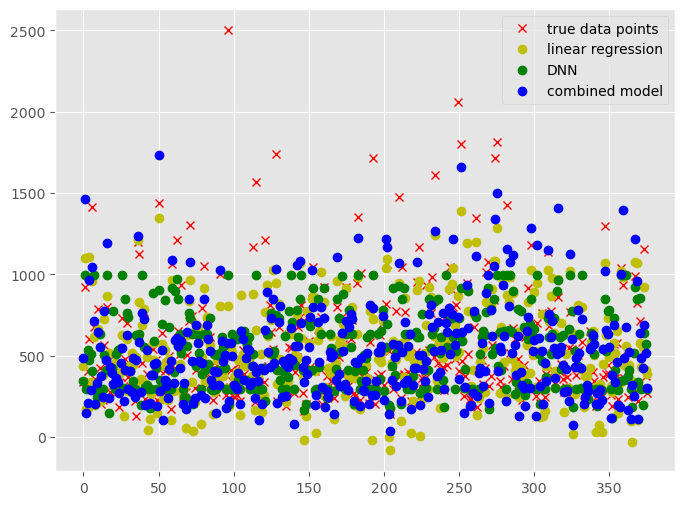

In [86]:
plt.plot(range(len(y_test)), y_test, 'rx')
plt.plot(range(len(y_test)), y_hat, 'yo')
plt.plot(range(len(y_test)), y_pred_1, 'go')
plt.plot(range(len(y_test)), y_pred_2, 'bo')
plt.legend(["true data points", "linear regression", "DNN", "combined model"])
plt.show()